# ML703 Project: Probabilistic Air Quality Forecasting with Bayesian Inference

**Team Members**: Muhra AlMahri, Ayesha Alhammadi  
**Dataset**: Hourly PM2.5 Air Quality Data (India)  
**Goal**: Compare traditional ARIMA with Bayesian models (BSTS and GPR) for uncertainty-aware forecasting.

In [ ]:
!pip install pymc arviz --quiet
!pip install scikit-learn --quiet
!pip install properscoring

In [ ]:
# Imports
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error
import properscoring as ps
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns

sns.set(style='whitegrid')

## 1. Data Preprocessing

In [ ]:
# Load the data
df = pd.read_csv('/content/air-quality-india 1.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)
df = df.asfreq('H')  # Set frequency to hourly
df['PM2.5'].interpolate(method='time', inplace=True)
daily_pm25 = df['PM2.5'].resample('D').mean()

<ipython-input-3-d8d268b960ee>:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq('H')  # Set frequency to hourly
<ipython-input-3-d8d268b960ee>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['PM2.5'].interpolate(method='time', inplace=True)


## 2. Baseline Model: SARIMA

In [ ]:
data_subset = daily_pm25[-200:]
train = data_subset[:-45]
test = data_subset[-45:]

In [ ]:
train_data = daily_pm25[:-100]
test_data = daily_pm25[-100:]

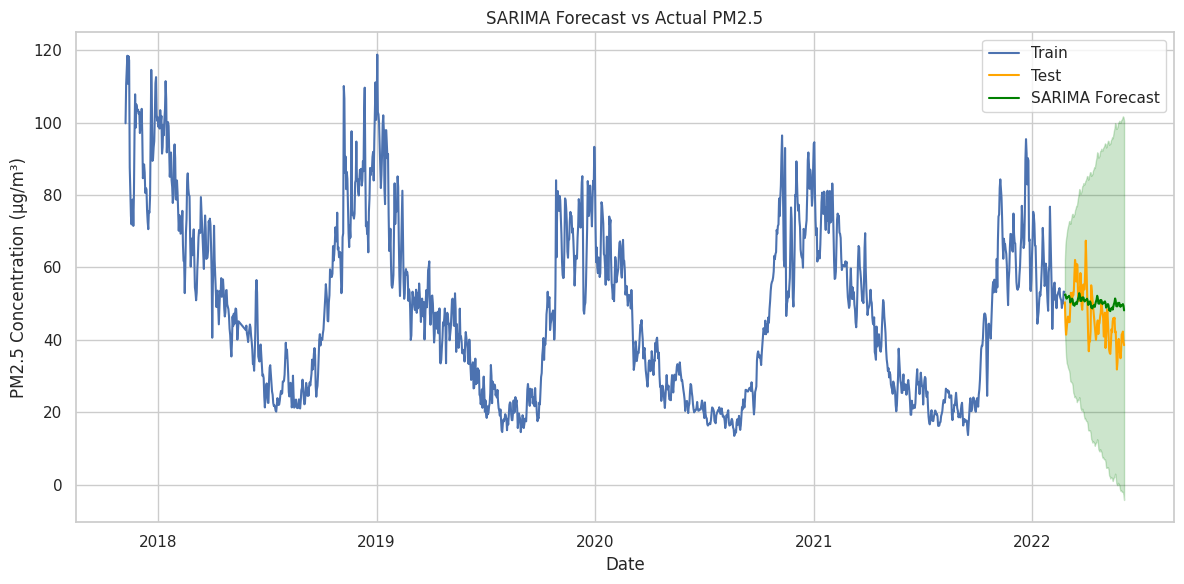

In [ ]:
# Fit SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_1= SARIMAX(train_data,
                order=(2, 1, 2),
                seasonal_order=(1, 1, 1, 30),  # Monthly pattern
                enforce_stationarity=False,
                enforce_invertibility=False)

results_1 = model_1.fit(disp=False)

# Forecast
forecast_obj_1 = results_1.get_forecast(steps=len(test_data))
forecast_mean_1 = forecast_obj_1.predicted_mean
conf_int_1 = forecast_obj_1.conf_int()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test', color='orange')
plt.plot(forecast_mean_1.index, forecast_mean_1, label='SARIMA Forecast', color='green')
plt.fill_between(forecast_mean_1.index, conf_int_1.iloc[:, 0], conf_int_1.iloc[:, 1], color='green', alpha=0.2)
plt.title("SARIMA Forecast vs Actual PM2.5")
plt.xlabel("Date")
plt.ylabel("PM2.5 Concentration (µg/m³)")
plt.legend()
plt.tight_layout()
plt.show()

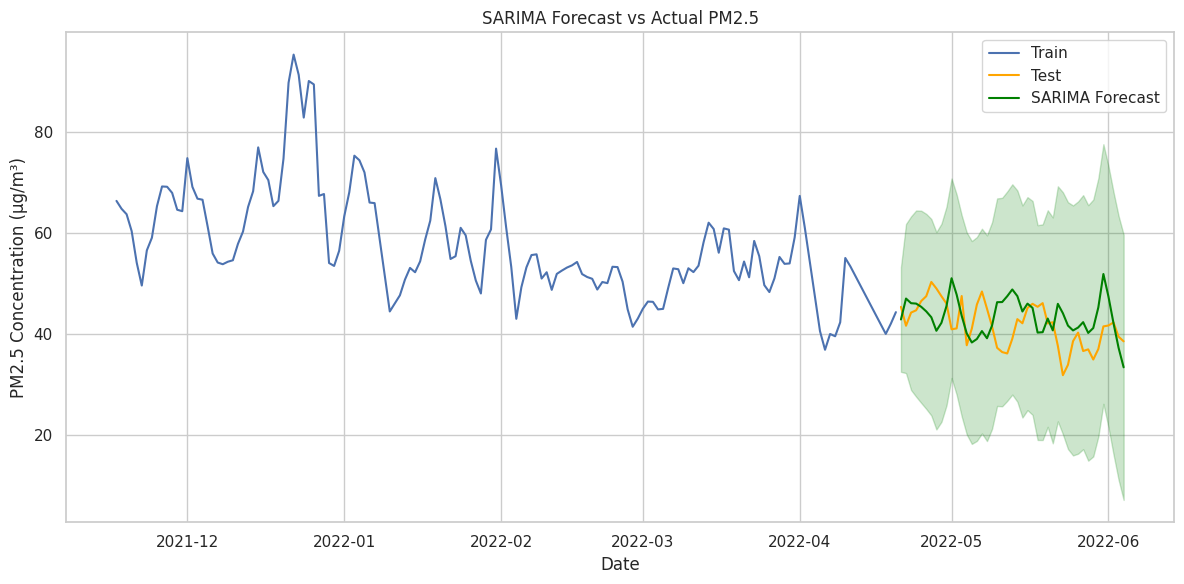

In [ ]:
# Fit SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train,
                order=(2, 1, 2),
                seasonal_order=(1, 1, 1, 30),  # Monthly pattern
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)

# Forecast
forecast_obj = results.get_forecast(steps=len(test))
forecast_mean = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(forecast_mean.index, forecast_mean, label='SARIMA Forecast', color='green')
plt.fill_between(forecast_mean.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)
plt.title("SARIMA Forecast vs Actual PM2.5")
plt.xlabel("Date")
plt.ylabel("PM2.5 Concentration (µg/m³)")
plt.legend()
plt.tight_layout()
plt.show()

## 3. Bayesian Structural Time Series (BSTS)

*Placeholder for PyMC3 or PyStan implementation of BSTS.*

In [ ]:
# 📦 Install PyMC and dependencies (first cell in Colab)
!pip install pymc arviz --quiet

/usr/local/lib/python3.11/dist-packages/pymc/distributions/timeseries.py:297: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: local_subtensor_merge
ERROR:pytensor.graph.rewriting.basic:node: Subtensor{i}(Subtensor{start:stop}.0, 0)
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pytensor/tensor/rewrit

Output()

ERROR:pymc.stats.convergence:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


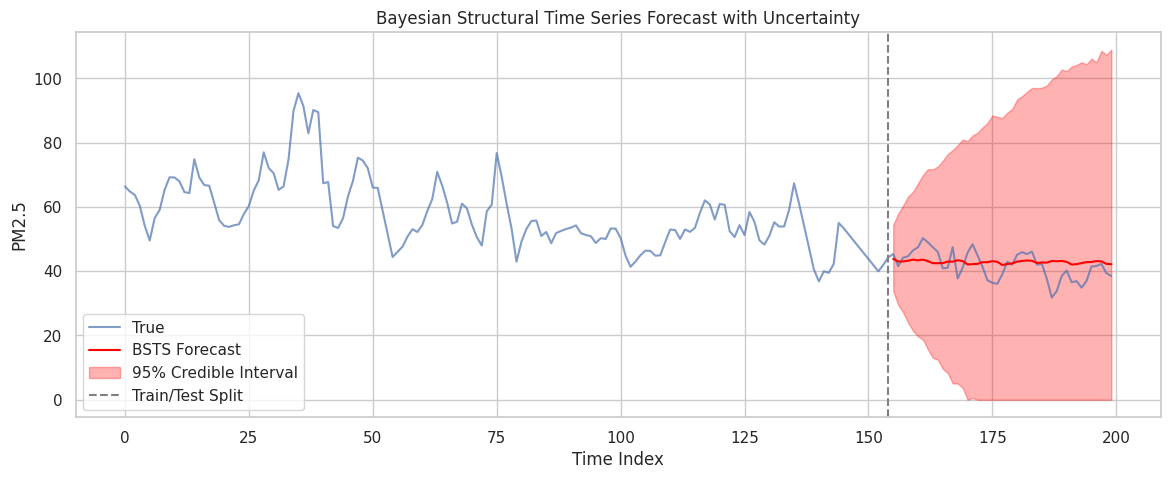

In [ ]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

# ✂️ Use last 200 days for modeling
y = daily_pm25[-200:].values
t = np.arange(len(y))
y_train = y[:-45]
t_train = t[:-45]
t_test = t[-45:]

# 🧠 PyMC model: BSTS with random walk + seasonality
with pm.Model() as bsts_model:
    sigma_level = pm.Exponential("sigma_level", 1.0)
    sigma_obs = pm.Exponential("sigma_obs", 1.0)

    # Local level as a random walk
    level = pm.GaussianRandomWalk("level", sigma=sigma_level, shape=len(t_train))

    # Weekly seasonality component
    period = 7
    seasonal_effect = pm.Normal("seasonal_effect", mu=0, sigma=1, shape=period)
    seasonality = pm.Deterministic("seasonality", seasonal_effect[t_train % period])

    mu = level + seasonality

    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma_obs, observed=y_train)

    trace = pm.sample(1000, tune=1000, return_inferencedata=True, target_accept=0.95)

# 🔮 Forecasting
n_future = len(t_test)
n_samples = trace.posterior.sizes["chain"] * trace.posterior.sizes["draw"]

level_samples = trace.posterior["level"].stack(sample=("chain", "draw")).values
seasonal_effect_samples = trace.posterior["seasonal_effect"].stack(sample=("chain", "draw")).values
sigma_level_samples = trace.posterior["sigma_level"].stack(sample=("chain", "draw")).values
sigma_obs_samples = trace.posterior["sigma_obs"].stack(sample=("chain", "draw")).values

last_level = level_samples[-1, :]
future_levels = np.zeros((n_future, n_samples))
for i in range(n_future):
    noise = np.random.normal(0, sigma_level_samples, size=n_samples)
    last_level += noise
    future_levels[i, :] = last_level

# Compute future seasonality by repeating the pattern
future_seasonality = np.zeros_like(future_levels)
for i in range(n_future):
    seasonal_idx = t_test[i] % 7
    future_seasonality[i, :] = seasonal_effect_samples[seasonal_idx, :]

forecast_samples = future_levels + future_seasonality
forecast_mean = np.mean(forecast_samples, axis=1)
lower_bound = np.percentile(forecast_samples, 2.5, axis=1)
upper_bound = np.percentile(forecast_samples, 97.5, axis=1)

# Clip lower bound at 0 (since PM2.5 cannot be negative)
clipped_lower_bound = np.clip(lower_bound, 0, None)

# Plot
plt.figure(figsize=(14,5))
plt.plot(t, y, label="True", alpha=0.7)
plt.plot(t_test, forecast_mean, label="BSTS Forecast", color='red')
plt.fill_between(t_test, clipped_lower_bound, upper_bound, color='red', alpha=0.3, label="95% Credible Interval")
plt.axvline(x=t_train[-1], color='gray', linestyle='--', label="Train/Test Split")
plt.title("Bayesian Structural Time Series Forecast with Uncertainty")
plt.xlabel("Time Index")
plt.ylabel("PM2.5")
plt.legend()
plt.show()

In [ ]:
from statsmodels.tsa.statespace.structural import UnobservedComponents
model = UnobservedComponents(y_train, level='local level', seasonal=30)
results = model.fit()
forecast = results.get_forecast(steps=len(test))
pred_mean = forecast.predicted_mean

## 4. Gaussian Process Regression (GPR)

*Placeholder for implementation using `scikit-learn` or `GPy`.*

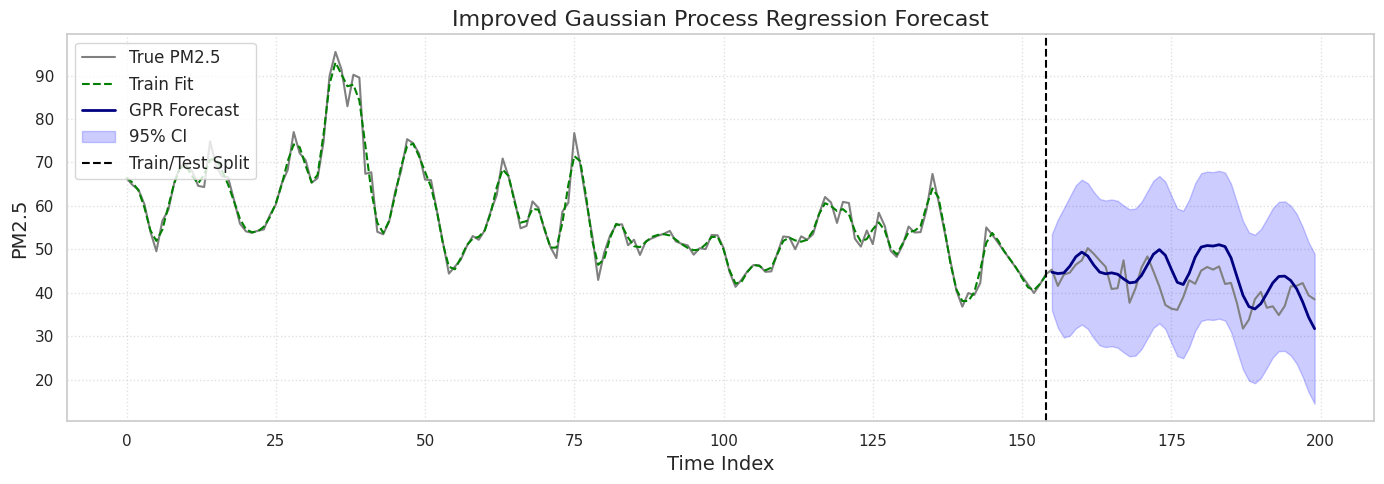

In [ ]:
# 📚 Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RationalQuadratic, ExpSineSquared, WhiteKernel,
    RBF, DotProduct, ConstantKernel as C
)
from sklearn.preprocessing import StandardScaler

# 🧪 Use last 200 days
y = daily_pm25[-200:].values
X = np.arange(len(y)).reshape(-1, 1)

X_train = X[:-45]
y_train = y[:-45]
X_test = X[-45:]
y_true = y[-45:]

# 📏 Normalize X
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# 📏 Normalize y
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

# 🔧 Composite Kernel: long-term, periodic, local, linear, noise
kernel = (
    C(1.0, (1e-2, 1e2)) *
    (RationalQuadratic(length_scale=1.0, alpha=10.0) +
     ExpSineSquared(length_scale=1.0, periodicity=7.0) +
     RBF(length_scale=5.0)) +
    DotProduct() +
    WhiteKernel(noise_level=1)
)

# 🧠 GPR Model
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)
gpr.fit(X_train_scaled, y_train_scaled)

# 📈 Predict both train and test
y_test_pred_scaled, sigma_scaled = gpr.predict(X_test_scaled, return_std=True)
y_train_pred_scaled, _ = gpr.predict(X_train_scaled, return_std=True)

# 🎯 Inverse transform predictions
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).ravel()
sigma = sigma_scaled * scaler_y.scale_[0]

# 📊 Plot
plt.figure(figsize=(14, 5))
plt.plot(X, y, label="True PM2.5", color="gray", linewidth=1.5)
plt.plot(X_train, y_train_pred, label="Train Fit", color="green", linestyle="--", linewidth=1.5)
plt.plot(X_test, y_test_pred, label="GPR Forecast", color="navy", linewidth=2)
plt.fill_between(X_test.ravel(), y_test_pred - 1.96 * sigma, y_test_pred + 1.96 * sigma,
                 alpha=0.2, color="blue", label="95% CI")
plt.axvline(X_train[-1], color="black", linestyle="--", label="Train/Test Split")
plt.title("Improved Gaussian Process Regression Forecast", fontsize=16)
plt.xlabel("Time Index", fontsize=14)
plt.ylabel("PM2.5", fontsize=14)
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend(loc="upper left", fontsize=12)
plt.tight_layout()
plt.show()

## 5. Evaluation Metrics

> Add blockquote



In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


# Ground truth
y_true = y[-45:]
forecast_sarima = forecast_mean[:len(test)]  # Safety trim
# Ensure both arrays are the same shape
assert y_test_pred.shape == y_true.shape, "Prediction and ground truth shapes do not match!"

# RMSE and MAE
rmse_sarima = np.sqrt(mean_squared_error(y_true, forecast_sarima))
mae_sarima = mean_absolute_error(y_true, forecast_sarima)

rmse_gpr = np.sqrt(mean_squared_error(y_true, y_test_pred))
mae_gpr = mean_absolute_error(y_true, y_test_pred)

rmse_bsts = np.sqrt(mean_squared_error(y_true, pred_mean))
mae_bsts = mean_absolute_error(y_true, pred_mean)

# Print results
print("Model Evaluation Metrics (Test Set - Last 45 Days):\n")
print(f"SARIMA  → RMSE: {rmse_sarima:.2f}, MAE: {mae_sarima:.2f}")
print(f"GPR    → RMSE: {rmse_gpr:.2f}, MAE: {mae_gpr:.2f}")
print(f"BSTS   → RMSE: {rmse_bsts:.2f}, MAE: {mae_bsts:.2f}")

Model Evaluation Metrics (Test Set - Last 45 Days):

SARIMA  → RMSE: 4.42, MAE: 3.66
GPR    → RMSE: 4.92, MAE: 4.18
BSTS   → RMSE: 5.78, MAE: 4.53


## Uncertainty  

### SARIMA

In [ ]:
# From the SARIMA code
conf_int = forecast_obj.conf_int()
interval_width = conf_int.iloc[:, 1] - conf_int.iloc[:, 0]
sarima_avg_uncertainty = interval_width.mean()

print(f"SARIMA average 95% CI width: {sarima_avg_uncertainty:.2f}")

SARIMA average 95% CI width: 42.97


###BSTS

In [ ]:

forecast_bsts = results.get_forecast(steps=len(test))  # not forecast()

# Get the confidence intervals (95%)
conf_int_bsts = forecast_bsts.conf_int()

# Assuming conf_int_bsts is a NumPy array of shape (n_steps, 2)
lower_bound = conf_int_bsts[:, 0]
upper_bound = conf_int_bsts[:, 1]

# Calculate width of each interval
interval_width_bsts = upper_bound - lower_bound

# Compute average uncertainty
bsts_avg_uncertainty = np.mean(interval_width_bsts)

print(f"BSTS average 95% CI width: {bsts_avg_uncertainty:.2f}")


BSTS average 95% CI width: 90.37


###GPR

In [ ]:
gpr_avg_uncertainty = np.mean(2 * 1.96 * sigma)  # 95% CI width

print(f"GPR average 95% CI width: {gpr_avg_uncertainty:.2f}")

GPR average 95% CI width: 33.27


### Comparison

In [ ]:
# Create a DataFrame for easy display
uncertainty_df = pd.DataFrame({
    'Model': ['SARIMA', 'BSTS', 'GPR'],
    'Avg 95% CI Width (µg/m³)': [
        sarima_avg_uncertainty,
        bsts_avg_uncertainty,
        gpr_avg_uncertainty
    ]
})

# Display the table sorted by lowest uncertainty
uncertainty_df.sort_values(by='Avg 95% CI Width (µg/m³)', inplace=True)

print(uncertainty_df.to_string(index=False))

 Model  Avg 95% CI Width (µg/m³)
   GPR                 33.271910
SARIMA                 42.971019
  BSTS                 90.374649
